In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import seaborn as sns
import cv2
import tqdm

J = os.path.join

df = pd.read_csv("../data/train_5fold.csv")
root = J(os.environ["DATASET_ROOT"], "bcd2022", "alenic_train_images_1024")
root_json = J(os.environ["DATASET_ROOT"], "bcd2022", "alenic_train_json_1024")

In [2]:
json_files = glob.glob(J(root_json, "*.json"))
dicom_data = {}
for f in json_files:
    with open(f, "r") as fp:
        f_dict = json.load(fp)
        for key,v in f_dict.items():
            dicom_data[key] = v
print(len(dicom_data.keys()))

54706


In [3]:
dicom_data["24889_1007866781"]

{'Rows': 3328,
 'Cols': 2560,
 'NumberOfFrames': 1,
 'SamplesPerPixel': 1,
 'PlanarConfiguration': None,
 'BitsAllocated': 16,
 'BytesAllocated': 2,
 'BitsStored': 12,
 'PixelRepresentation': False,
 'dtype': 'H',
 'PhotometricInterpretation': 'MONOCHROME2',
 'WindowCenter': 2047.0,
 'WindowWidth': 4096.0,
 'RescaleIntercept': 0.0,
 'RescaleSlope': 1.0}

In [4]:
df_dicom = pd.DataFrame()

width = []
center = []
patient_id = []
image_id = []
rows = []
cols = []
interpret = []
bits = []
for k, key in enumerate(dicom_data.keys()):
    pid, imgid = key.split("_")
    patient_id.append(int(pid))
    image_id.append(int(imgid))
    width.append(dicom_data[key]["WindowWidth"])
    center.append(dicom_data[key]["WindowCenter"])
    rows.append(dicom_data[key]["Rows"])
    cols.append(dicom_data[key]["Cols"])
    interpret.append(dicom_data[key]["PhotometricInterpretation"])
    bits.append(dicom_data[key]["BitsStored"])

df_dicom["patient_id"] = patient_id
df_dicom["image_id"] = image_id
df_dicom["file"] = df_dicom["patient_id"].astype(str)+ "_"+df_dicom["image_id"].astype(str) + ".npz"
df_dicom["window_width"] = width
df_dicom["window_center"] = center
df_dicom["rows"] = rows
df_dicom["cols"] = cols
df_dicom["interpret"] = interpret
df_dicom["bits"] = bits


In [5]:
df_m = pd.merge(df, df_dicom, how="left", on = ["patient_id", "image_id"])
df_m.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
fold                           0
file                           0
window_width                   0
window_center                  0
rows                           0
cols                           0
interpret                      0
bits                           0
dtype: int64

In [6]:
image_files = glob.glob(J(root, "*.npz"))
len(image_files)==len(df)

True

In [106]:
df_m["bits"].value_counts()

12    45369
16     8267
10     1070
Name: bits, dtype: int64

In [107]:
df_m["window_width"].value_counts()

4096.00    37058
1091.97     7900
1500.00     4314
900.00      3960
1023.00     1070
           ...  
1008.77        1
995.97         1
999.17         1
3988.00        1
1203.97        1
Name: window_width, Length: 63, dtype: int64

In [108]:
df_m.to_csv("../data/train_5fold_aug.csv", index=False)

In [3]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,3
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,3
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,2
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,1
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,1
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,3


# Transform

In [12]:
def npz_preprocessing(image, mode, quant=None, window: tuple=None):
    # normalize
    if window is not None:
        c, w = window
        imin = c - w//2
        imax = c + w//2
        image[image<imin]=imin
        image[image>=imax]=imax
    if quant is not None:
        data = image.flatten()
        q1 = np.quantile(data, q=quant[0])
        q2 = np.quantile(data, q=quant[1])
        imin = q1
        imax = q2
        image[image<imin]=imin
        image[image>=imax]=imax
    else:
        imin = image.min()
        imax = image.max()
    
    print(imin, imax)
    
    image = (image-imin).astype(np.float32)/(imax-imin)

    if mode == "MONOCHROME1":
        image = 1-image

    return (image*255).astype(np.uint8)

29390_1376178944.npz 0 3092


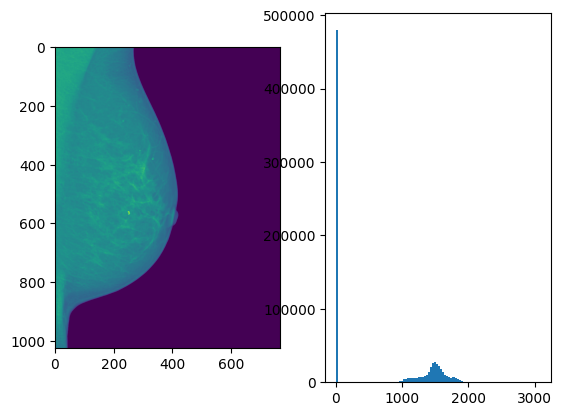

In [11]:
f = df_m.file.sample(1).values[0]
image = np.load(J(root, f))["data"]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image)
ax[1].imshow(npz_preprocessing(image, quant=(0.1, 0.9)))
ax[1].hist(image.flatten(), bins=100)
print(f, image.min(), image.max())

# Analyze different bits configurations

In [86]:
strange=[]
for f in tqdm.tqdm(df_m.file.values):
    if pd.isna(f): continue
    image = np.load(J(root, f))["data"]
    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(image)
    #ax[1].hist(image.flatten(), bins=100)
    if image.max() > 5000:
        print(f, image.min(), image.max())
        strange.append(f)

  6%|██                                   | 3113/54706 [00:18<05:14, 164.20it/s]

13258_1334530318.npz 1419 5028


  9%|███▎                                 | 4832/54706 [00:28<04:45, 174.80it/s]

15183_1786106476.npz 1323 5572


 17%|██████▎                              | 9412/54706 [00:56<05:04, 148.96it/s]

2004_1533367273.npz 1170 5220


 20%|███████▏                            | 11012/54706 [01:05<04:32, 160.50it/s]

21805_2073820963.npz 1501 5060


 31%|███████████                         | 16808/54706 [01:38<03:44, 168.50it/s]

27770_176859678.npz 0 65295
27770_2045216615.npz 0 65295
27770_647254933.npz 0 65295
27770_1365270904.npz 0 65295
27770_1962061164.npz 0 65295


 34%|████████████▍                       | 18849/54706 [01:51<03:34, 167.15it/s]

29898_166573135.npz 0 6404


 39%|██████████████▏                     | 21491/54706 [02:06<03:07, 177.01it/s]

32801_2106729079.npz 92 5348


 49%|█████████████████▋                  | 26864/54706 [02:38<02:58, 156.12it/s]

38697_201322322.npz 1384 5060


 50%|█████████████████▊                  | 27081/54706 [02:39<02:58, 154.42it/s]

3889_907459879.npz 1364 5380


 54%|███████████████████▍                | 29571/54706 [02:54<02:45, 151.72it/s]

4154_173327354.npz 1280 5924


 61%|██████████████████████              | 33454/54706 [03:17<02:14, 158.12it/s]

45867_1693260172.npz 1381 5348


 74%|██████████████████████████▌         | 40352/54706 [03:59<01:32, 154.38it/s]

53558_1698405286.npz 685 5572


 74%|██████████████████████████▊         | 40733/54706 [04:01<01:32, 150.36it/s]

53999_325945481.npz 719 5124


 77%|███████████████████████████▋        | 42161/54706 [04:10<01:10, 178.03it/s]

55495_1273612891.npz 722 5732


 77%|███████████████████████████▊        | 42331/54706 [04:11<01:15, 163.23it/s]

55630_595142649.npz 338 5092


100%|████████████████████████████████████| 54706/54706 [05:24<00:00, 168.65it/s]


In [87]:
df_m[df_m["file"].isin(strange)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,density,machine_id,difficult_negative_case,file,window_width,window_center,rows,cols,interpret,bits
3081,2,13258,1334530318,R,CC,62.0,0,0,0,NaN,...,NaN,29,False,13258_1334530318.npz,1091.97,1802.31,5355.0,4915.0,MONOCHROME1,16.0
4800,2,15183,1786106476,L,CC,54.0,0,0,0,NaN,...,NaN,29,False,15183_1786106476.npz,1091.97,1802.31,5355.0,4915.0,MONOCHROME1,16.0
9386,2,2004,1533367273,L,CC,57.0,0,0,0,NaN,...,NaN,29,False,2004_1533367273.npz,1091.97,1802.31,5355.0,4915.0,MONOCHROME1,16.0
10992,2,21805,2073820963,L,CC,69.0,0,0,0,NaN,...,NaN,29,False,21805_2073820963.npz,1091.97,1802.31,5355.0,4915.0,MONOCHROME1,16.0
16772,1,27770,176859678,L,CC,51.0,0,0,0,NaN,...,B,49,False,27770_176859678.npz,4096.00,2047.00,4096.0,3328.0,MONOCHROME2,12.0
16773,1,27770,2045216615,L,MLO,51.0,0,0,0,NaN,...,B,49,False,27770_2045216615.npz,4096.00,2047.00,4096.0,3328.0,MONOCHROME2,12.0
16774,1,27770,647254933,R,CC,51.0,0,0,0,2.0,...,B,49,False,27770_647254933.npz,4096.00,2047.00,4096.0,3328.0,MONOCHROME2,12.0
16775,1,27770,1365270904,R,MLO,51.0,0,0,0,2.0,...,B,49,False,27770_1365270904.npz,4096.00,2047.00,4096.0,3328.0,MONOCHROME2,12.0
16776,1,27770,1962061164,R,CC,51.0,0,0,0,2.0,...,B,49,False,27770_1962061164.npz,4096.00,2047.00,4096.0,3328.0,MONOCHROME2,12.0
18827,2,29898,166573135,R,MLO,60.0,0,0,0,NaN,...,NaN,29,False,29898_166573135.npz,1091.97,1802.31,5355.0,4915.0,MONOCHROME1,16.0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.68it/s]


27770_2045216615.npz 0 65295


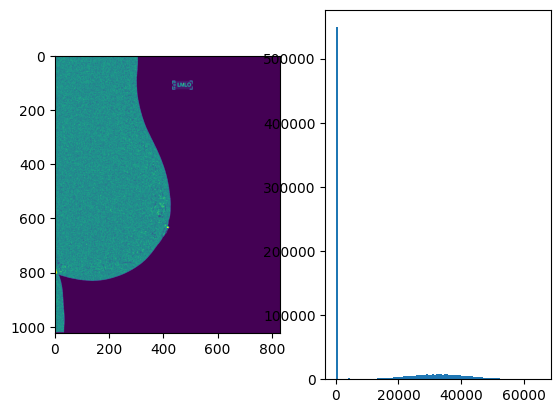

In [89]:
myset=["27770_2045216615.npz"]
for f in tqdm.tqdm(df_m[df_m["file"].isin(myset)]["file"]):
    if pd.isna(f): continue
    image = np.load(J(root, f))["data"]
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].hist(image.flatten(), bins=100)
    print(f, image.min(), image.max())